### Imports

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import platform
import sys
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import keras
from keras.applications import InceptionV3
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras import models
from keras.models import Sequential, Model
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import plot_model
import tensorflow as tf

### Enable Cuda if OS is Windows

In [62]:
if platform.system() == 'Windows':
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [63]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Set path and get all classes. ".DS_Store" needs to be removed on MacOS againa

In [83]:
d = '/home/sebastian/Documents/Hauptprojekt/Daten_sorted.nosync/'
classes = (os.listdir(d))
print(os.device_encoding) 
if "._.DS_Store" in classes:
    classes.remove("._.DS_Store")
if ".DS_Store" in classes:
    classes.remove(".DS_Store")

<built-in function device_encoding>


In [84]:
print(classes)

['sales_order', 'purchase_order', 'utility_bill', 'debit_note', 'order', 'receipt', 'proforma', 'tax_invoice', 'credit_note']


### Global variables

In [96]:
img_size = 299
batch_size = 32
epochs = 40
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4321
channels = 3
learning_rate = 0.00001

### Get all data

In [86]:
total_set = []
total_labels = []
counter_tax = 0 
counter_order = 0


for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            label = root.split(os.path.sep)[-1]
            if label == "tax_invoice":
                counter_tax +=1
                if counter_tax % 10 == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            elif label == "order":
                counter_order +=1
                if counter_order % 5 == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            else:    
                path = os.path.join(root, file)
                total_set.append(path)
                total_labels.append(label)
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted.nosync/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-052(1).jpg
GetClass :  sales_order
Label :  sales_order


/home/sebastian/Documents/Hauptprojekt/Daten_sorted.nosync/receipt/synthetic-410651d35003486c860e6985-594(1).jpg


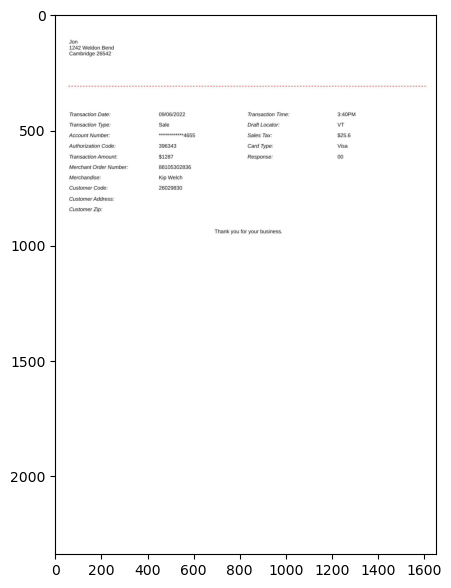

/home/sebastian/Documents/Hauptprojekt/Daten_sorted.nosync/order/synthetic-dd977fac28e44dfbaff727b7-265(1).jpg


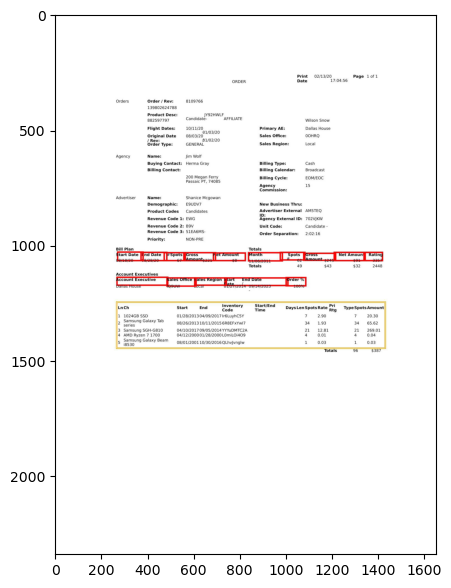

/home/sebastian/Documents/Hauptprojekt/Daten_sorted.nosync/order/synthetic-479646a8739446fcae92b067-292(1).jpg


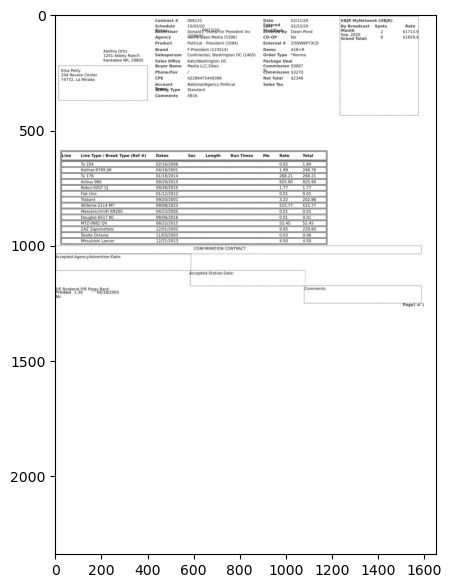

In [87]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()

### Sorting data in usable sets¶

In [88]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))
    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(val_set[200])
print(val_label[200])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted.nosync/purchase_order/synthetic-4b12606f2f334ca3bba989cd-317(1).jpg
purchase_order


### Visualize class distribution

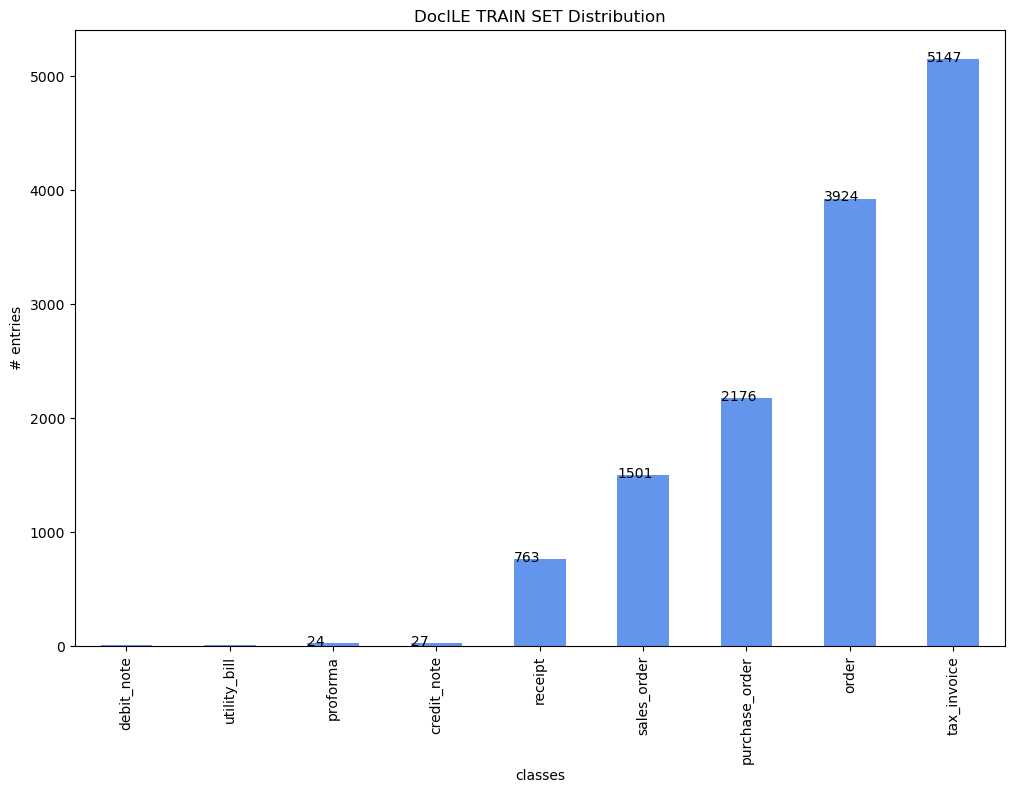

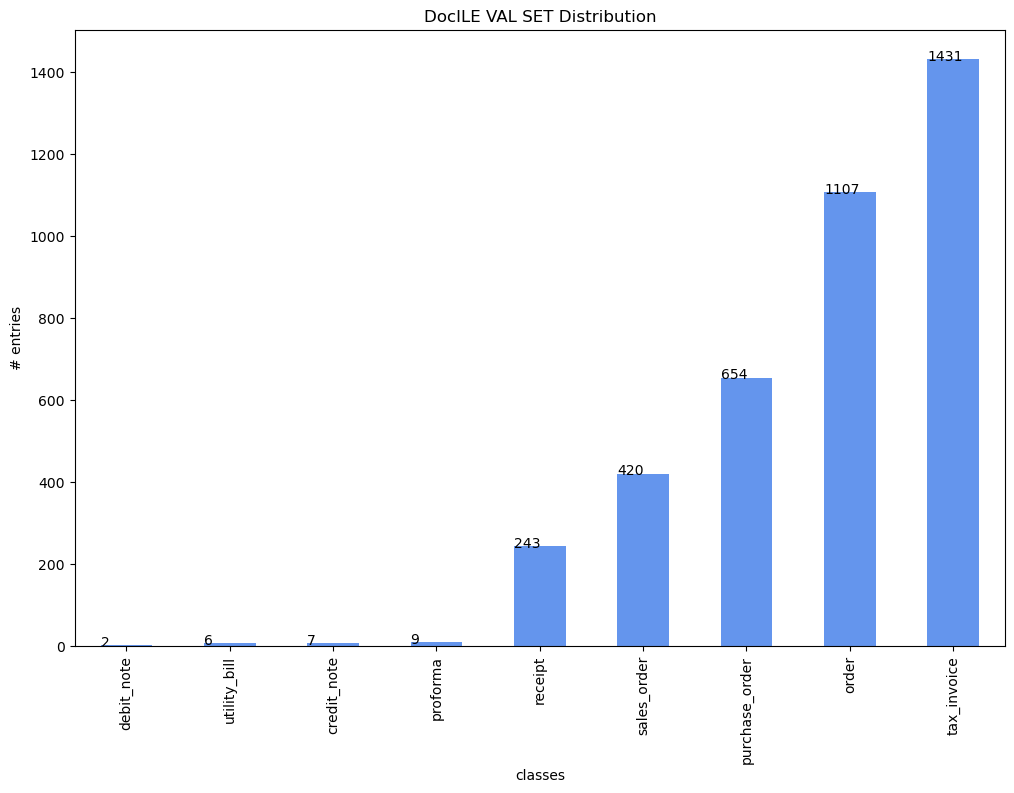

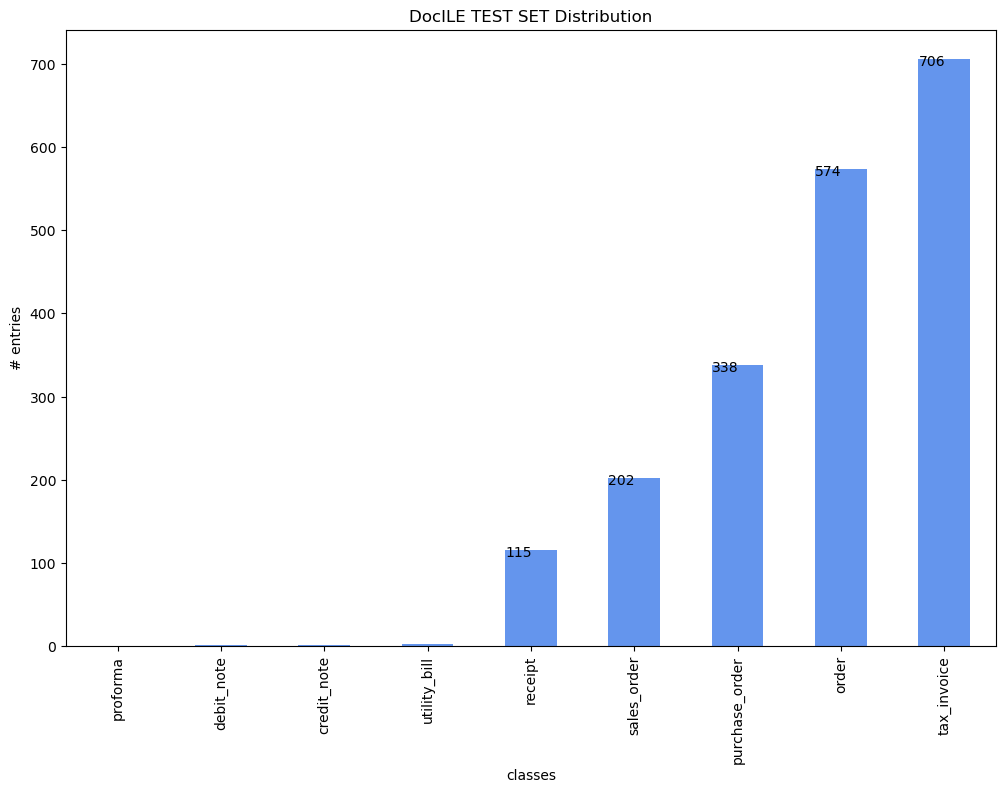

In [89]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

### Preprocess data (resize and transform to Numpy array)

In [90]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
        #some files contain a "/._" so they can not be loaded. This is a know file copy error.
        if "/._" not in img_set[i]:
            processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
        else: train_label.pop(i)
        
    
    return processed_img
    
x_train = process_images(train_set)

In [91]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
        #some files contain a "/._" so they can not be loaded. This is a know file copy error.
        if "/._" not in img_set[i]:
            processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
        else: test_label.pop(i)
        
    
    return processed_img
    
x_test = process_images(test_set)

In [92]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
        #some files contain a "/._" so they can not be loaded. This is a know file copy error.
        if "/._" not in img_set[i]:
            processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
        else: val_label.pop(i)
        
    
    return processed_img
    
x_val = process_images(val_set)

train shape :  (13576, 299, 299, 3)
(13576, 9)
test shape :  (1939, 299, 299, 3)
(1939, 9)
valdiation shape :  (3878, 299, 299, 3)
(3878, 9)
receipt
[0 0 0 0 0 1 0 0 0]
['credit_note' 'debit_note' 'order' 'proforma' 'purchase_order' 'receipt'
 'sales_order' 'tax_invoice' 'utility_bill']


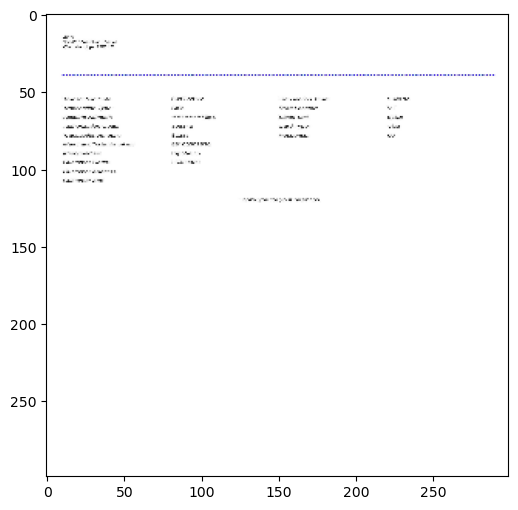

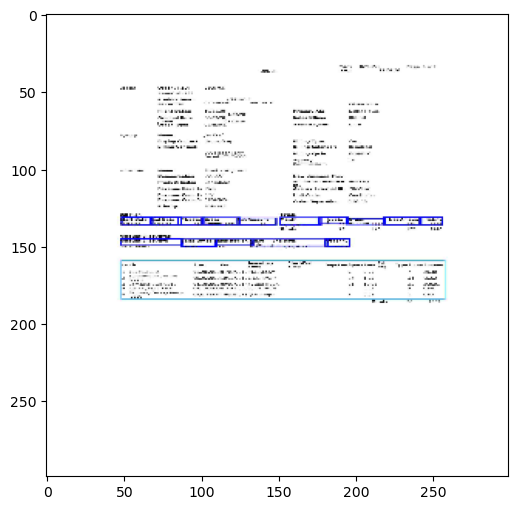

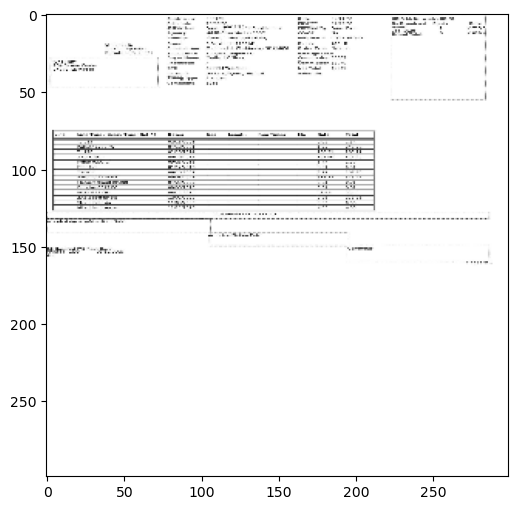

In [97]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(x_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(x_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(x_val)
y_val = lb.transform(np.array(val_label))

print("train shape : ", x_train.shape)
print(y_train.shape)
print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])

print(train_label[0])
print(y_train[0])
print(lb.classes_)

### Save the sets to .npy file for use after restarting runtime

In [98]:
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/x_train.npy', x_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/x_test.npy', x_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/y_train.npy', y_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/y_test.npy', y_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/x_val.npy', x_val)
np.save('//home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/y_val.npy', y_val)

### load sets after restarting runtime

In [108]:
x_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/x_train.npy')
x_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/x_test.npy')
y_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/y_train.npy')
y_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/y_test.npy')
x_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/x_val.npy')
y_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/Inceptionv3.nosync/y_val.npy')

In [109]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


Creating model (pretrained CNN) InceptionV3

In [110]:
base_model = InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

"""for layer in base_model.layers:
    layer.trainable = False"""
    
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_470 (Conv2D)         (None, 149, 149, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_470 (B  (None, 149, 149, 32)         96        ['conv2d_470[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_470 (Activation  (None, 149, 149, 32)         0         ['batch_normalizati

                                                                                                  
 conv2d_481 (Conv2D)         (None, 35, 35, 32)           6144      ['average_pooling2d_45[0][0]']
                                                                                                  
 batch_normalization_475 (B  (None, 35, 35, 64)           192       ['conv2d_475[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_477 (B  (None, 35, 35, 64)           192       ['conv2d_477[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_480 (B  (None, 35, 35, 96)           288       ['conv2d_480[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_487 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_487[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_488 (Activation  (None, 35, 35, 64)           0         ['batch_normalization_488[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 35, 35, 288)          0         ['activation_482[0][0]',      
                                                                     'activation_484[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_498 (Conv2D)         (None, 35, 35, 96)           55296     ['activation_497[0][0]']      
                                                                                                  
 batch_normalization_498 (B  (None, 35, 35, 96)           288       ['conv2d_498[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_498 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_498[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_49

                                                                                                  
 conv2d_500 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_503 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_502[0][0]']      
                                                                                                  
 conv2d_508 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_507[0][0]']      
                                                                                                  
 conv2d_509 (Conv2D)         (None, 17, 17, 192)          147456    ['average_pooling2d_48[0][0]']
                                                                                                  
 batch_normalization_500 (B  (None, 17, 17, 192)          576       ['conv2d_500[0][0]']          
 atchNorma

 activation_517 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_517[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_49 (Aver  (None, 17, 17, 768)          0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_510 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_513 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_512[0][0]']      
                                                                                                  
 conv2d_51

 atchNormalization)                                                                               
                                                                                                  
 activation_522 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_522[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_527 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_527[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_50 (Aver  (None, 17, 17, 768)          0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_532 (B  (None, 17, 17, 192)          576       ['conv2d_532[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_537 (B  (None, 17, 17, 192)          576       ['conv2d_537[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_532 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_532[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_541 (Conv2D)         (None, 8, 8, 320)            552960    ['activation_540[0][0]']      
                                                                                                  
 conv2d_545 (Conv2D)         (None, 8, 8, 192)            331776    ['activation_544[0][0]']      
                                                                                                  
 batch_normalization_541 (B  (None, 8, 8, 320)            960       ['conv2d_541[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_545 (B  (None, 8, 8, 192)            576       ['conv2d_545[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_552 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_552[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_553 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_553[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_554 (B  (None, 8, 8, 192)            576       ['conv2d_554[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_558 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_558[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_561 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_561[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_562 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_562[0][0
 )                                                                  ]']                           
          

### finetune model

In [111]:
#model = models.Sequential()

#model.add(base_model)
#model.add(layers.Flatten())
#model.add(layers.Dense(128, activation='relu',  name='dense'))
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model_InceptionV3.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_470 (Conv2D)         (None, 149, 149, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_470 (B  (None, 149, 149, 32)         96        ['conv2d_470[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_470 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_47

                                                                                                  
 conv2d_481 (Conv2D)         (None, 35, 35, 32)           6144      ['average_pooling2d_45[0][0]']
                                                                                                  
 batch_normalization_475 (B  (None, 35, 35, 64)           192       ['conv2d_475[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_477 (B  (None, 35, 35, 64)           192       ['conv2d_477[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_480 (B  (None, 35, 35, 96)           288       ['conv2d_480[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_487 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_487[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_488 (Activation  (None, 35, 35, 64)           0         ['batch_normalization_488[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 35, 35, 288)          0         ['activation_482[0][0]',      
                                                                     'activation_484[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_498 (Conv2D)         (None, 35, 35, 96)           55296     ['activation_497[0][0]']      
                                                                                                  
 batch_normalization_498 (B  (None, 35, 35, 96)           288       ['conv2d_498[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_498 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_498[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_49

                                                                                                  
 conv2d_500 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_503 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_502[0][0]']      
                                                                                                  
 conv2d_508 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_507[0][0]']      
                                                                                                  
 conv2d_509 (Conv2D)         (None, 17, 17, 192)          147456    ['average_pooling2d_48[0][0]']
                                                                                                  
 batch_normalization_500 (B  (None, 17, 17, 192)          576       ['conv2d_500[0][0]']          
 atchNorma

 activation_517 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_517[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_49 (Aver  (None, 17, 17, 768)          0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_510 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_513 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_512[0][0]']      
                                                                                                  
 conv2d_51

 atchNormalization)                                                                               
                                                                                                  
 activation_522 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_522[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_527 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_527[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_50 (Aver  (None, 17, 17, 768)          0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_532 (B  (None, 17, 17, 192)          576       ['conv2d_532[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_537 (B  (None, 17, 17, 192)          576       ['conv2d_537[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_532 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_532[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_541 (Conv2D)         (None, 8, 8, 320)            552960    ['activation_540[0][0]']      
                                                                                                  
 conv2d_545 (Conv2D)         (None, 8, 8, 192)            331776    ['activation_544[0][0]']      
                                                                                                  
 batch_normalization_541 (B  (None, 8, 8, 320)            960       ['conv2d_541[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_545 (B  (None, 8, 8, 192)            576       ['conv2d_545[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_552 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_552[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_553 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_553[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_554 (B  (None, 8, 8, 192)            576       ['conv2d_554[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_558 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_558[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_561 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_561[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_562 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_562[0][0
 )                                                                  ]']                           
          

In [112]:
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val))

Epoch 1/40
221/425 [==============>...............] - ETA: 20s - loss: 1.2933 - accuracy: 0.5428

KeyboardInterrupt: 

save Model

In [ ]:
model.save('/home/sebastian/Documents/Hauptprojekt/Models/InceptionV3-trained_model_all_layer.h5')

### Plot training accuracy and loss

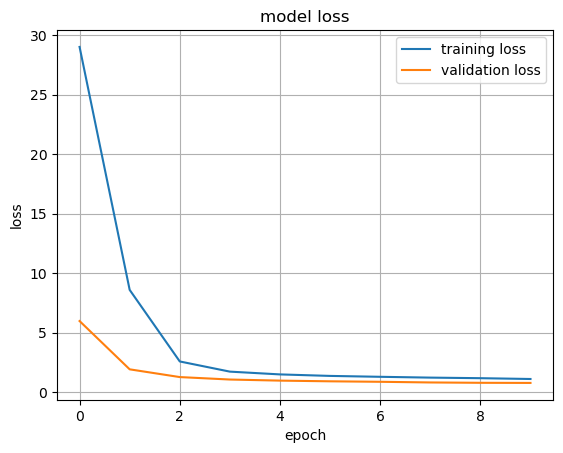

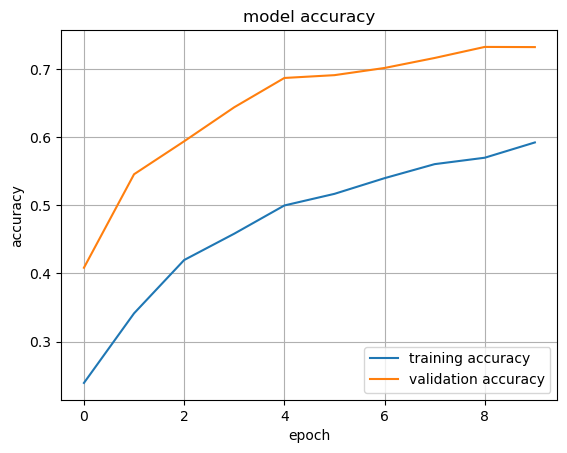

In [54]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.show()

### Plot prediction accuracy

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Use Model on test set

In [ ]:
predictions = model.predict_classes(x_test, verbose=1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_
false_pred = []

count_true = 0
count_false = 0

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
        false_pred.append(test_label[i])
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

Print wrong classifications per class

In [ ]:


print(f'"debit_note" was classified wrong {false_pred.count("debit_note")} time(s) out of 0 time(s)')
print(f'"proforma" was classified wrong {false_pred.count("proforma")} time(s) out of 3 time(s)')
print(f'"utility_bill" was classified wrong {false_pred.count("utility_bill")} time(s) out of 3 time(s)')
print(f'"credit_note" was classified wrong {false_pred.count("credit_note")} time(s) out of 4 time(s)')
print(f'"receipt" was classified wrong {false_pred.count("receipt")} time(s) out of 103 time(s)')
print(f'"sales_order" was classified wrong {false_pred.count("sales_order")} time(s) out of 194 time(s)')
print(f'"purchase_order" was classified wrong {false_pred.count("purchase_order")} time(s) out of 319 time(s)')
print(f'"order" was classified wrong {false_pred.count("order")} time(s) out of 2836 time(s)')
print(f'"tax_invoice" was classified wrong {false_pred.count("tax_invoice")} time(s) out of 7277 time(s)')

In [87]:
print(val_set)

['/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Daten_sorted.nosync/tax_invoice/synthetic-15ce44dd43af4f2fbe8aa920-811(1).jpg', '/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Daten_sorted.nosync/tax_invoice/synthetic-fce4d5fac5c14af3b4c375d3-992(1).jpg', '/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Daten_sorted.nosync/order/synthetic-c62990cb4561487eb20824e0-258(1).jpg', '/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Daten_sorted.nosync/receipt/synthetic-410651d35003486c860e6985-567(1).jpg', '/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Daten_sorted.nosync/tax_invoice/synthetic-89679c3d35524159b431d16a-856(1).jpg', '/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Daten_sorted.nosync/tax_invoice/synthetic-98cef569de05416d9041bb21-342(1).jpg', '/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Daten_sorted.nosync/tax_invoice/6703641143c34440a88088db(1).jpg', '/Users/sep/Documents/HAW/Vorlesung/HP/Hauptprojekt/Daten_sorted.nosync/sales_order/synthetic-6a8be